# Code Graveyard

For our own reference. Code that we have removed from our project but may require again are dumped here.

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot

# Import essential models and functions from sklearn
from sklearn.metrics import mean_squared_error,ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

sb.set() # set the default Seaborn style for graphics

### Dropping Outliers

We should also drop any outliers that may affect our model. We can observe some outliers for trestbps, chol, thalach and oldpeak variables from the boxplots. Let us begin by removing them.

In [ ]:
# We remove all the outliers all at once so that it does not affect the quantiles of future variables.
# To do this, we first store the lower and upper bounds of each variable in a list. 

lst = []

for v in num_var:
    IRQ = clean_data[v].quantile(0.75) - clean_data[v].quantile(0.25)
    upper = clean_data[v].quantile(0.75) + IRQ * 1.5
    lower = clean_data[v].quantile(0.25) - IRQ * 1.5
    outliers = clean_data[v][(clean_data[v] < lower) | (clean_data[v] > upper)]
    print(f"{v}: {outliers.shape[0]}")
    lst.append((lower, upper))

lst = list(zip(num_var, lst))

for v, (lower, upper) in lst:
    clean_data = clean_data[(clean_data[v] >= lower) & (clean_data[v] <= upper)]

print("\nNew dimension of clean_data:", clean_data.shape)

### Fixing Skew

We can also observe some skew for many of the numerical variables. Let us take a closer look at each of their skews by calling `.skew()` on each of the variables.

In [11]:
for v in num_var:
    print(f"{v}: {clean_data[v].skew().round(2)}")

age: -0.21
trestbps: 0.29
chol: 0.19
thalach: -0.43
oldpeak: 0.92


We can see that the skew values of `age`, `trestbps`, `chol` and `thalach` are below 0.5 and thus quite low. However, `oldpeak` has a very high positive skew value of 0.92, and we should address this. 

### Checking for Imbalance (Numerical Data)

To check for imbalance in numerical variables, we will be taking a look at their distributions as compared to the normal distribution. Since our dataset is relatively large (999 entries) we would expect a normal distribution if our dataset is balanced. We will be using a Quantile-Quantile (Q-Q) plot to check against a normal distribution.

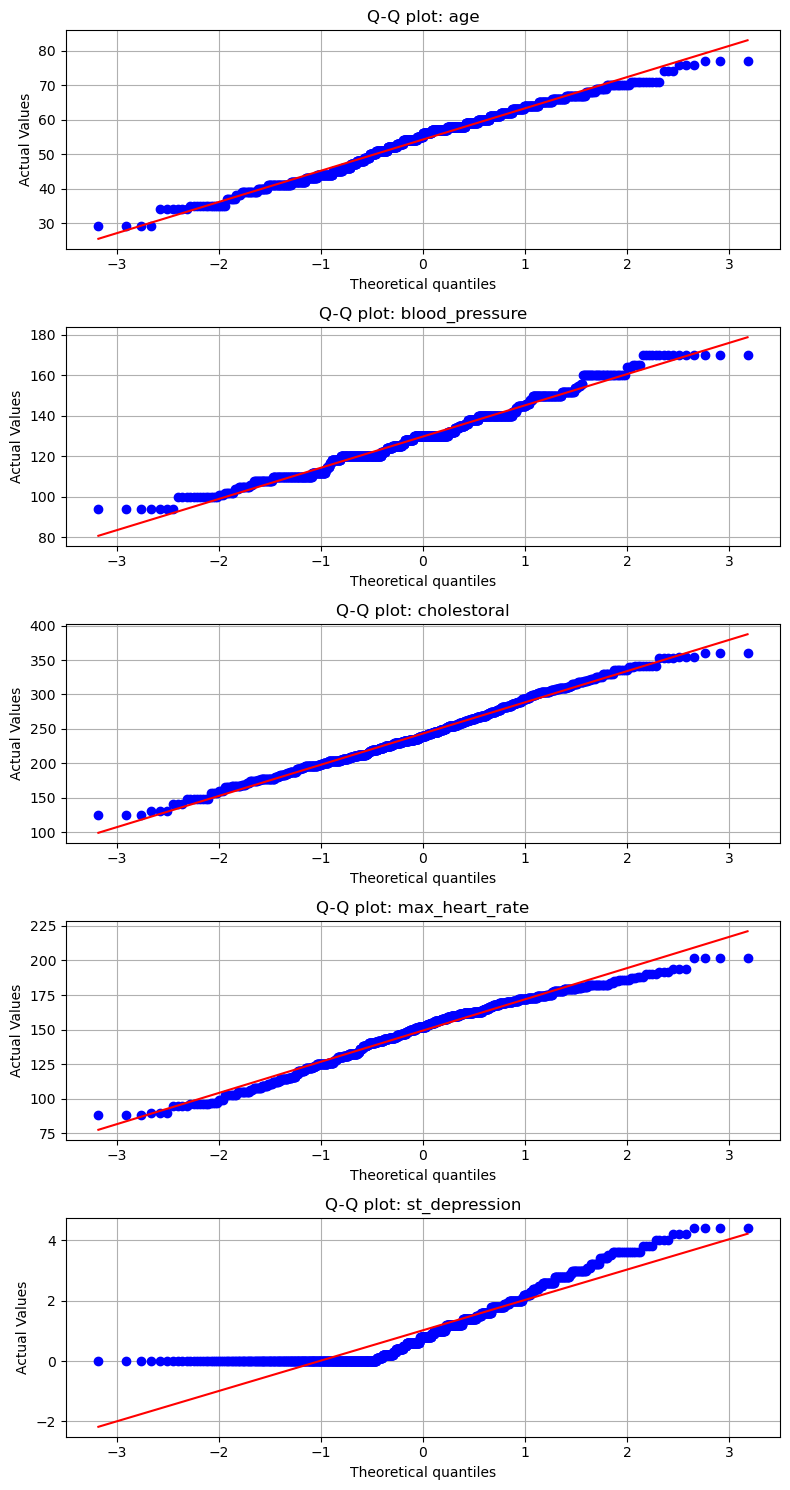

In [9]:
# Import the plot library
import matplotlib.pyplot as plt

# Import the stats library to use probplot
import scipy.stats as stats

# Loop through the numerical columns, ignoring index
f, axes = plt.subplots(5, 1, figsize = (8, 15))
for i, var in enumerate(num_var[1:]):
    ax = axes[i]
    stats.probplot(clean_data[var], dist="norm", plot=ax)
    ax.set_title(f'Q-Q plot: {var}')
    ax.set_xlabel('Theoretical quantiles')
    ax.set_ylabel('Actual Values')
    ax.grid(True)
    
plt.tight_layout()
plt.show()

### Intepreting our Q-Q Plots

Based on the graphs above we can see that most of them follow a normal distribution. Although there are some outliers in place the methods that we will be using later on are not sensitive to outliers, hence there is no need to correct most of our data for imbalance./

However we can see an abnormally in our Q-Q plots for `st_depression`. This is because `st_depression` is only able to start from 0. To better understand the `st_depression` data that we are working with lets take a look at the distribution of `st_depression`./

We will also be taking a look at the skew of `st_depression`.

Skewness of st_depression: 0.10112254711609758


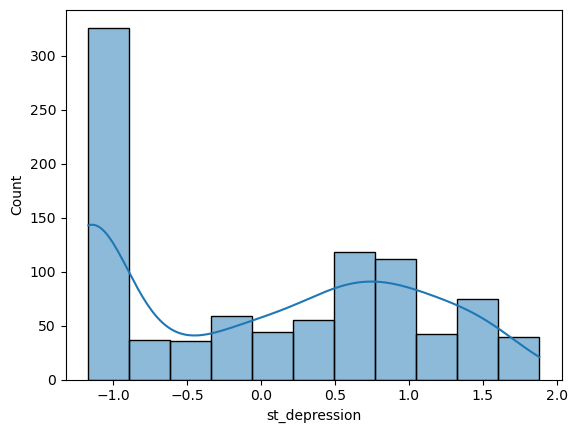

In [11]:
#Importing Yeo-Johnson
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')

# Fit the transformer with st_depression
pt.fit(clean_data[["st_depression"]])

# Transform the st_depression
# We use clean_data.loc to remove the error of python being unsure of whether its modifying the copy or original
clean_data.loc[:, "st_depression"] = pt.transform(clean_data[["st_depression"]])

#Check again for skewness and replot to see a difference
sb.histplot(data = clean_data["st_depression"],kde = True)

print("Skewness of st_depression: {}".format(clean_data["st_depression"].skew()))


### Reanalysing st_depression data

Taking a look at our new st_depression data, we can see that the imbalanced has been relatively fixed as the skewness is greatly reduced from ~1 to ~0.1

### Linearity of Logit

We shall check for this by plotting the logit of the dependent variable `target` against the independent variables in a scatterplot. We can also check for linearity with pearson's correlation. The formula for logit is given as: 

$Logit(p) = \log (\frac{p}{1 - p})$

where $p$ is odds of success and $1 - p$ is the odds of failure. We can get the estimated probabilities from our model with `predict_proba()`. Let us first check the linearity on the train set. 

In [71]:
proba_arr = logreg.predict_proba(X_train)

proba_arr

array([[0.63917884, 0.36082116],
       [0.99853912, 0.00146088],
       [0.07530512, 0.92469488],
       ...,
       [0.98927407, 0.01072593],
       [0.64224822, 0.35775178],
       [0.97273364, 0.02726636]])

In [72]:
import math

# Make the logit function
logit = lambda x : math.log(x[1] / x[0])

target = clean_data_ohe["heart_disease"]
clean_data_ohe = clean_data_ohe.drop(["heart_disease"], axis = 1)

# Get the estimated probabilities
proba_arr = logreg.predict_proba(clean_data_ohe)

# Apply the logit function across all probability values
logit_arr = np.array(list(map(logit, proba_arr)))

In [73]:
clean_data_ohe = pd.concat([clean_data_ohe, pd.DataFrame(logit_arr), target], axis = 1).rename({0 : "logit"}, axis = 1)

clean_data_ohe["logit"]

0     -2.534019
1     -2.239099
2     -2.466036
3     -2.479390
4     -1.889022
         ...   
995    1.862671
996   -5.792748
997   -3.574456
998    3.102041
999   -4.229098
Name: logit, Length: 1000, dtype: float64

age correlation: -0.2981186487051819
blood_pressure correlation: -0.19510021284188517
cholesterol correlation: -0.13869380929844735
max_heart_rate correlation: 0.5646988140856807
st_depression correlation: -0.5808561853942172


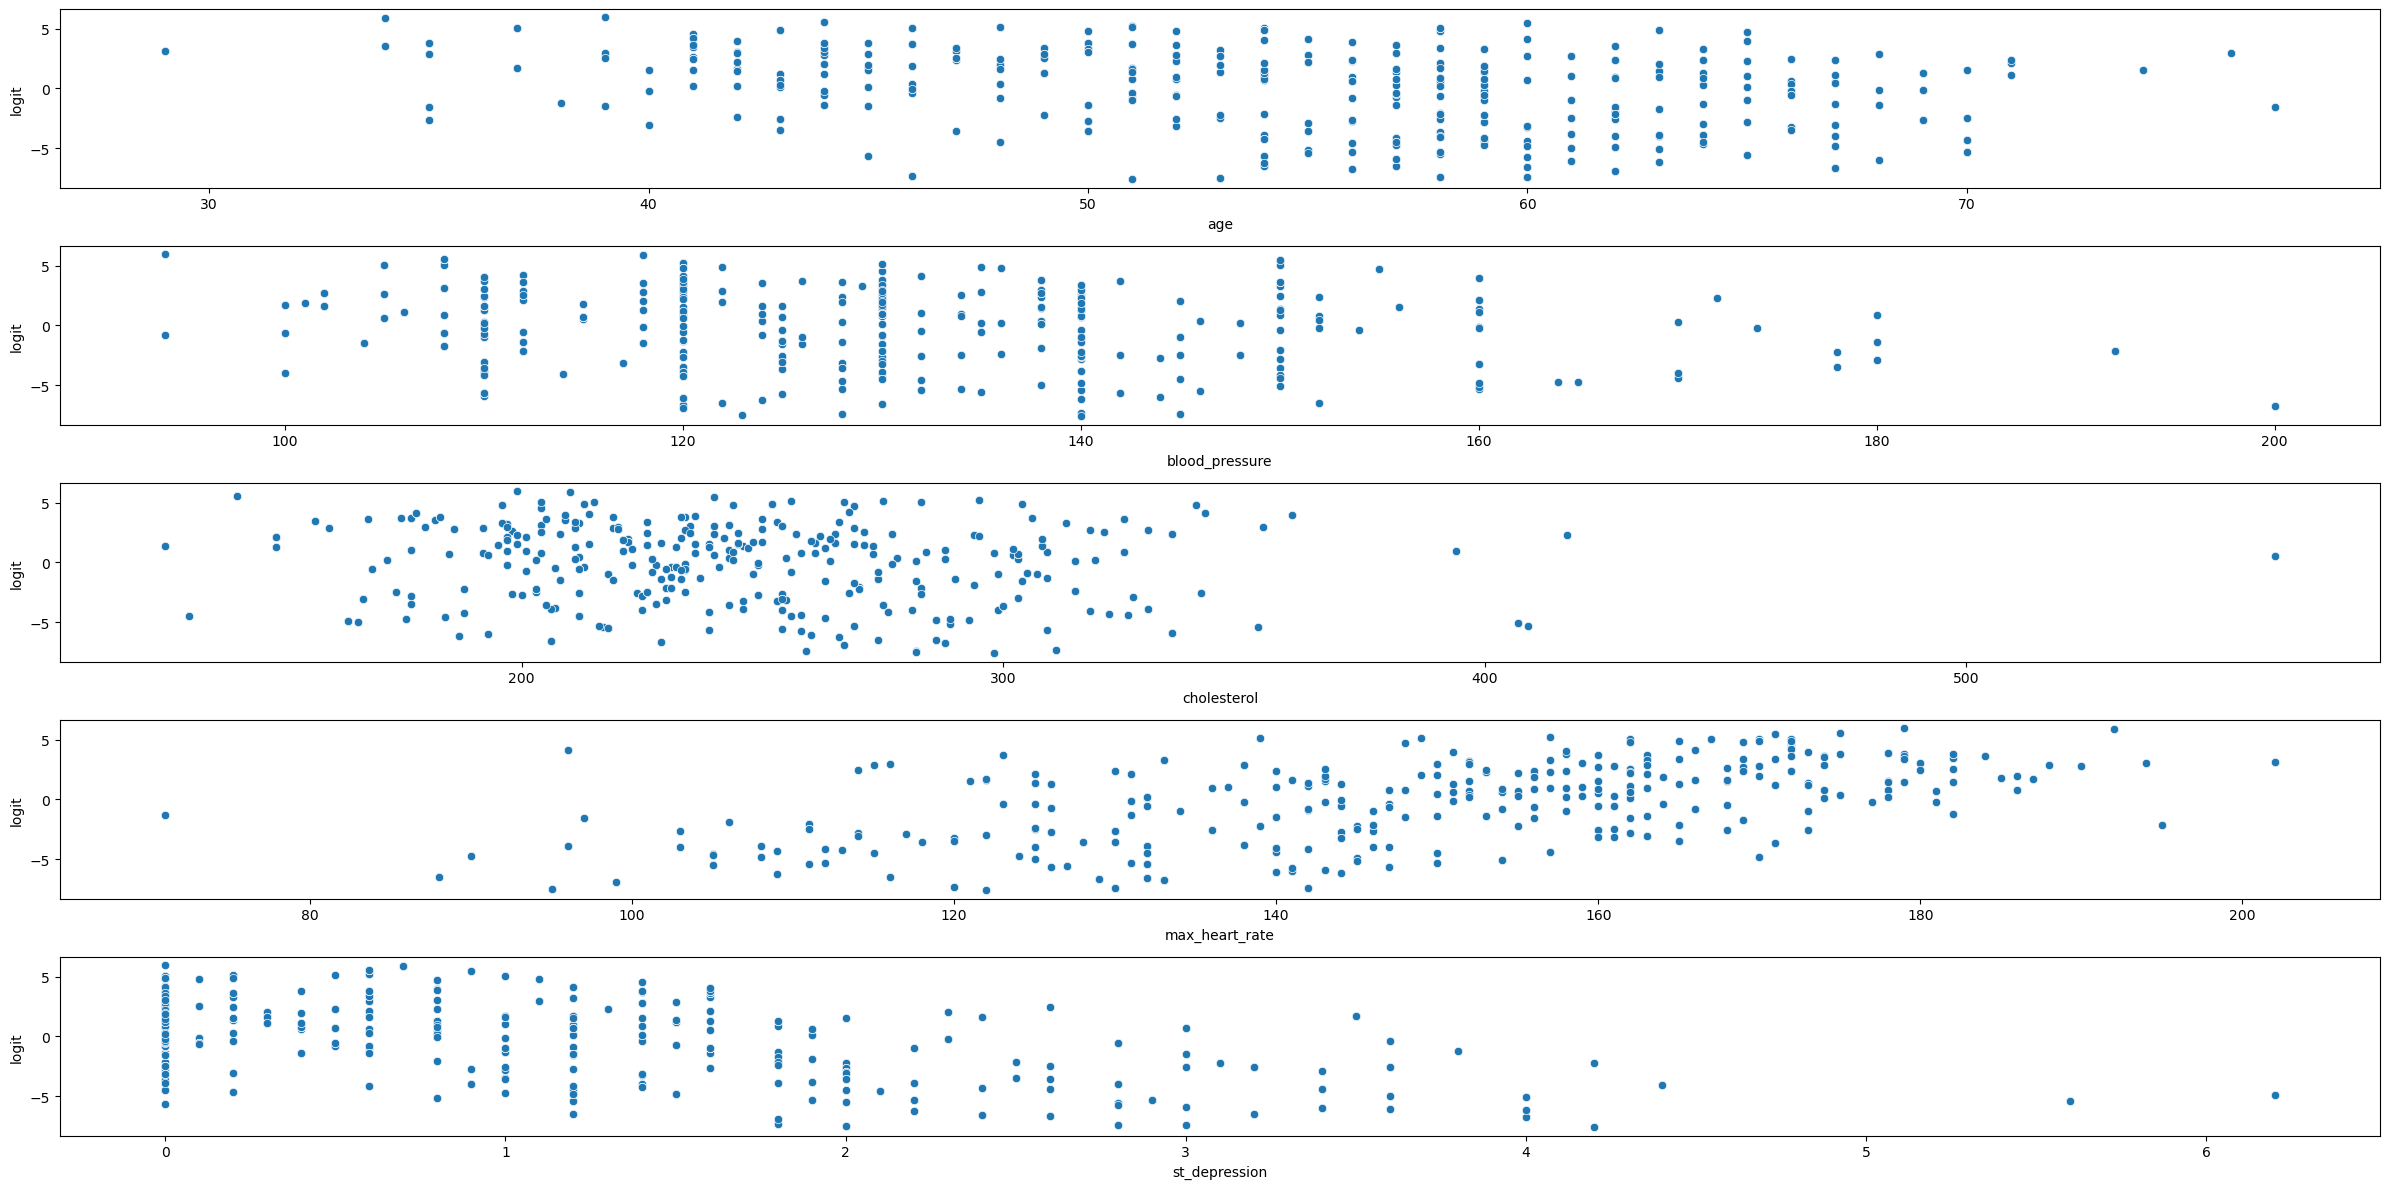

In [74]:
f, axes = plt.subplots(len(num_var), 1, figsize = (24, 12))

for i, var in enumerate(num_var):
    sb.scatterplot(data = clean_data_ohe, x = var, y = "logit", ax = axes[i]).set(xlabel = var)
    print(f"{var} correlation:", clean_data_ohe[var].corr(clean_data_ohe["logit"]))

f.tight_layout()

# Ok, something probably went wrong here. 

In [167]:
# Import the encoder from sklearn
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

# One-Hot Encoding of categorical predictors
cat_pred = clean_data[cat_var].drop("heart_disease", axis = 1)
ohe.fit(cat_pred)

cat_pred_ohe = pd.DataFrame(ohe.transform(cat_pred).toarray(), 
             columns = ohe.get_feature_names_out(cat_pred.columns))

# Check the encoded variables
cat_pred_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sex_0                      1000 non-null   float64
 1   sex_1                      1000 non-null   float64
 2   chest_pain_0               1000 non-null   float64
 3   chest_pain_1               1000 non-null   float64
 4   chest_pain_2               1000 non-null   float64
 5   chest_pain_3               1000 non-null   float64
 6   fasting_blood_sugar_0      1000 non-null   float64
 7   fasting_blood_sugar_1      1000 non-null   float64
 8   resting_ecg_result_0       1000 non-null   float64
 9   resting_ecg_result_1       1000 non-null   float64
 10  resting_ecg_result_2       1000 non-null   float64
 11  exercise_induced_angina_0  1000 non-null   float64
 12  exercise_induced_angina_1  1000 non-null   float64
 13  new_st_depression_0        1000 non-null   float6

In [168]:
# Concatenate with the numeric variables
clean_data_ohe = pd.concat([clean_data[num_var], cat_pred_ohe, clean_data["heart_disease"]], axis = 1)

print("Dimensions:", clean_data_ohe.shape)

# Check the final DataFrame
clean_data_ohe

Dimensions: (1000, 31)


,age,blood_pressure,cholesterol,max_heart_rate,st_depression,sex_0,sex_1,chest_pain_0,chest_pain_1,chest_pain_2,...,slope_1,slope_2,num_affected_vessels_0,num_affected_vessels_1,num_affected_vessels_2,num_affected_vessels_3,defect_type_1,defect_type_2,defect_type_3,heart_disease
0,52,125,212,168,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
1,53,140,203,155,3.1,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,70,145,174,125,2.6,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,61,148,203,161,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
4,62,138,294,106,1.9,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,59,140,221,164,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
996,60,125,258,141,2.8,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
997,47,110,275,118,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
998,50,110,254,159,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1


A simple solution is to continue to drop another value, but the $VIF$ value for `defect_type_2` is only slightly greater than 5. 

Removing it could represent a loss of useful information and could actually affect the model's accuracy more than if we had kept it, especially if our model is not overfitted. Because L2 regularisation (Ridge Regression) is performed by default for the `LogisticRegression()` model in `sklearn`, it can help to address multicollinearity and overfitting in our model. L2 regularisation works by increasing bias to decrease variance by changing the $\alpha$ value to generalise the model so it performs better on test data by trading off accuracy on the train data. 

We can compare the performance of the models between keeping `defect_type_2` without regularisation and dropping `defect_type_2` and using regularisation. In this way, we can determine if the trade-off between multicollinearity and loss of useful information is acceptable. 

First, we drop `defect_type_2` and do not use any form of regularisation, since our VIF values should be acceptable after the removal of another `defect_type` encoded variable. 

In [415]:
# Once again, we drop defect_type_2 and check for VIF values

# variance_inflation_factor expects the presence of a constant in the matrix of explanatory variables
# We can add a constant column using add_constant from statsmodels

independent_vars = add_constant(clean_data_encoded.drop(["heart_disease", "defect_type_2"], axis = 1))

VIF_df = pd.DataFrame(independent_vars.columns).rename({0 : "VARIABLES"}, axis = 1) # rename variable column

VIF_df["VIF"] = [vif(independent_vars, i) for i in range(len(independent_vars.columns))]

VIF_df

,VARIABLES,VIF
0,const,215.565314
1,age,1.506595
2,blood_pressure,1.218910
3,cholesterol,1.140209
4,max_heart_rate,1.696440
5,st_depression,2.275706
6,sex_1,1.246329
7,chest_pain_1,1.523554
8,chest_pain_2,1.492798
9,chest_pain_3,1.262253


Indeed—our VIF values are appropriate after dropping another `defect_type` encoded variable.

In [416]:
from sklearn.linear_model import LogisticRegression

# Split the data into predictors and response
X = clean_data_encoded.drop(["heart_disease", "defect_type_2"], axis = 1)
y = clean_data_encoded["heart_disease"]

# Split the dataset into train and test (80:20 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

logreg = LogisticRegression(penalty = "none")
logreg.fit(X_train, y_train)

print("Classes:", logreg.classes_)
print("Intercept:", logreg.intercept_)
print("Coefficients:", [i.round(4) for i in logreg.coef_[0]])

Classes: [0 1]
Intercept: [-0.07512376]
Coefficients: [0.0119, -0.0106, -0.0064, 0.022, -0.5124, -1.4266, 0.5808, 1.2657, 0.9817, 0.3702, 0.2624, -0.07, -1.0749, 0.8667, -1.6078, 0.743, -1.3329]


C:\Users\brand\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Goodness of Fit of Model

Let us check its classification accuracy and its confusion matrix. 

In [417]:
# Predict target with model
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", logreg.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", logreg.score(X_test, y_test))
print()

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.87625

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.855



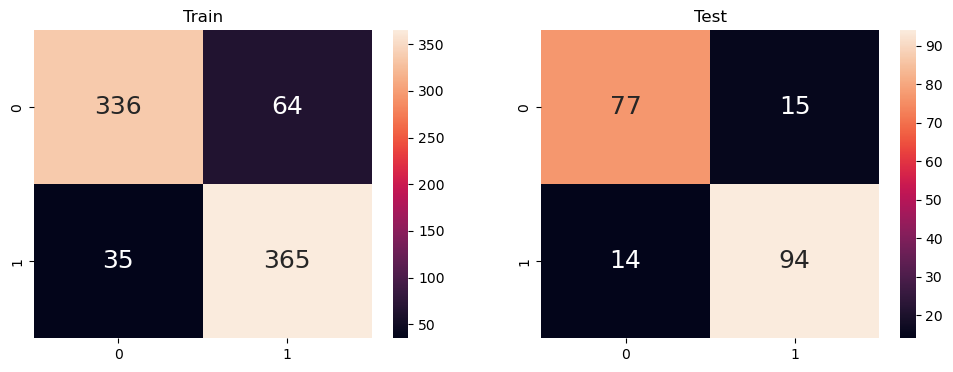

In [418]:
from sklearn.metrics import confusion_matrix

# Define a function to visualise confusion matrix
def viz_cmatrix(y_train, y_train_pred, y_test, y_test_pred):
    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))

    sb.heatmap(confusion_matrix(y_train, y_train_pred),
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
    sb.heatmap(confusion_matrix(y_test, y_test_pred), 
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

    axes[0].set_title("Train")
    axes[1].set_title("Test")
    
viz_cmatrix(y_train, y_train_pred, y_test, y_test_pred)

In [419]:
# Define a function to print rate metrics
def printMetrics(true, pred): 
    FP = confusion_matrix(true, pred)[0][1]
    FN = confusion_matrix(true, pred)[1][0]
    TP = confusion_matrix(true, pred)[1][1]
    TN = confusion_matrix(true, pred)[0][0]
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    TNR = TN / (TN + FP)
    FNR = FN / (FN + TP)
    print("TPR:\t", TPR)
    print("FPR:\t", FPR)
    print("TNR:\t", TNR)
    print("FNR:\t", FNR)
    print()

print("TRAIN SET:")
printMetrics(y_train, y_train_pred)

print("TEST SET:")
printMetrics(y_test, y_test_pred)

TRAIN SET:
TPR:	 0.9125
FPR:	 0.16
TNR:	 0.84
FNR:	 0.0875

TEST SET:
TPR:	 0.8703703703703703
FPR:	 0.16304347826086957
TNR:	 0.8369565217391305
FNR:	 0.12962962962962962



Now, we keep `defect_type_2` but perform L2 regularisation.

In [420]:
# Split the data into predictors and response
X = clean_data_encoded.drop(["heart_disease"], axis = 1)
y = clean_data_encoded["heart_disease"]

# Split the dataset into train and test (80:20 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

print("Classes:", logreg.classes_)
print("Intercept:", logreg.intercept_)
print("Coefficients:", [i.round(4) for i in logreg.coef_[0]])

Classes: [0 1]
Intercept: [-0.12541387]
Coefficients: [0.016, -0.0174, -0.007, 0.0246, -0.5751, -1.2989, 0.6009, 1.2881, 0.9741, 0.4502, 0.2894, -0.084, -1.1118, 0.9521, 0.6384, -0.8864, 0.6443, -1.5291]


C:\Users\brand\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [421]:
# Predict target with model
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", logreg.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", logreg.score(X_test, y_test))
print()

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8775

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.84



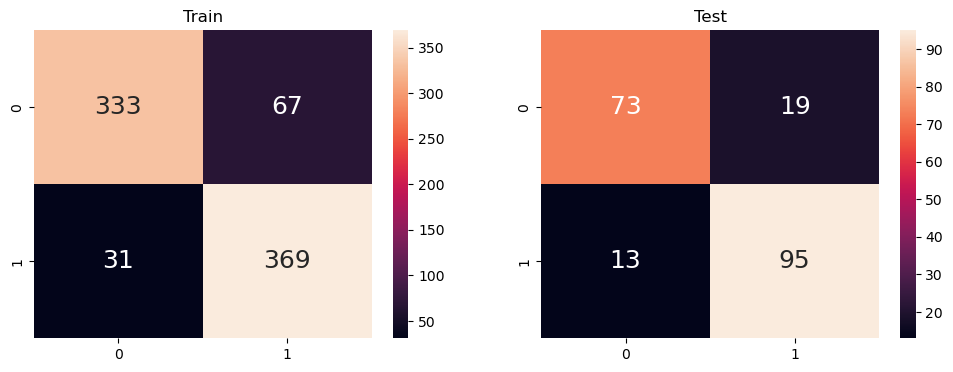

In [422]:
viz_cmatrix(y_train, y_train_pred, y_test, y_test_pred)

In [423]:
print("TRAIN SET:")
printMetrics(y_train, y_train_pred)

print("TEST SET:")
printMetrics(y_test, y_test_pred)

TRAIN SET:
TPR:	 0.9225
FPR:	 0.1675
TNR:	 0.8325
FNR:	 0.0775

TEST SET:
TPR:	 0.8796296296296297
FPR:	 0.20652173913043478
TNR:	 0.7934782608695652
FNR:	 0.12037037037037036



### Comparison

While the model that keeps `defect_type_2` and performs L2 regularisation has a very slight edge in accuracy on the train data (0.8775 > 0.87625), it has a lower accuracy on the test data (0.84 < 0.855) compared to the model which drops `defect_type_2` and does not perform L2 regularisation. Thus, we should adopt the former approach: dropping `defect_type_2` and not performing L2 regularisation on our model. 